In [3]:
import pandas as pd
from typing import Tuple
from datetime import timedelta
import matplotlib
matplotlib.use('TkAgg') 
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.dates as mdates
import os
import matplotlib.patches as mpatches
from extra_plotting import *
from typing import Tuple
import pandas as pd


In [4]:
if __name__ == '__main__':
    data_path = '/home/cate/Downloads/codes_marc/data/B10.csv'
    df = pd.read_csv(data_path, sep=';', low_memory=False, dtype={'iti_duration': float})
    # 1 for analisis of trained mice, 0 for untrained
    #print(df['task'].unique())
    # df['task'].isin(['S4_5_single_pulse', 'S4_5_second_condition', 'S4_5_third_condition'])
    # df['prev_iti_duration'] = df.groupby('session')['iti_duration'].shift()
    # #new_df = df[(df['prev_iti_duration'] > 0.5) & (df['prev_iti_duration'] < 10)] #third condition
    # #new_df = df[df['prev_iti_duration'] > 0.5]
    # df['prev_opto_bool'] = df.groupby('session')['opto_bool'].shift()
    # trained = 1
    # automated = 0
    # new_df = parsing(df,trained,1,automated,0)
    # print(new_df)
    #new_df = df
    #glm(new_df)

In [5]:
def parse_sessions(df, training_sessions, target_session):
    """
    Estrae training e target session dai dati completi.

    Args:
        df (pd.DataFrame): Dataframe originale con colonna 'session'.
        training_sessions (list[int]): lista di sessioni da usare per il training.
        target_session (int): sessione specifica target.

    Returns:
        df_train (pd.DataFrame), df_target (pd.DataFrame)
    """
    df['task'].isin(['S4_5'])
    df_train = df[df['session'].isin(training_sessions)].reset_index(drop=True)
    df_target = df[df['session'] == target_session].reset_index(drop=True)

    return df_train, df_target


In [6]:
def obt_regressors(df: pd.DataFrame, n: int) -> Tuple[pd.DataFrame, str]:
    """
    Summary:
    This function processes the data needed to obtain the regressors and derives the 
    formula for the glm

    Args:
        df ([Dataframe]): [dataframe with experimental data]
        n ([int]): [number of trials back considered]

    Returns:
        new_df([Dataframe]): [dataframe with processed data restricted to the regression]
        regressors_string([string]) :  [regression formula]
    """
    # Select the columns needed for the regressors
    new_df = df[['session', 'trial', 'task', 'outcome', 'side', 'iti_duration', 'probability_r']].copy()
    new_df['outcome_bool'] = np.where(new_df['outcome'] == "correct", 1, 0)
    
    # Keep only sessions with more than 50 trials
    session_counts = new_df['session'].value_counts()
    mask = new_df['session'].isin(session_counts[session_counts > 50].index)
    new_df = new_df[mask]
    
    # Define choice column based on outcome and side
    new_df.loc[(new_df['outcome_bool'] == 0) & (new_df['side'] == 'right'), 'choice'] = 'left'
    new_df.loc[(new_df['outcome_bool'] == 1) & (new_df['side'] == 'left'), 'choice'] = 'left'
    new_df.loc[(new_df['outcome_bool'] == 0) & (new_df['side'] == 'left'), 'choice'] = 'right'
    new_df.loc[(new_df['outcome_bool'] == 1) & (new_df['side'] == 'right'), 'choice'] = 'right'
    new_df['choice'].fillna('other', inplace=True)
    
    # Define r_plus and r_minus
    new_df.loc[new_df['outcome_bool'] == 0, 'r_plus'] = 0
    new_df.loc[(new_df['outcome_bool'] == 1) & (new_df['choice'] == 'left'), 'r_plus'] = -1
    new_df.loc[(new_df['outcome_bool'] == 1) & (new_df['choice'] == 'right'), 'r_plus'] = 1
    new_df['r_plus'] = pd.to_numeric(new_df['r_plus'].fillna(0), errors='coerce')
    
    new_df.loc[new_df['outcome_bool'] == 1, 'r_minus'] = 0
    new_df.loc[(new_df['outcome_bool'] == 0) & (new_df['choice'] == 'left'), 'r_minus'] = -1
    new_df.loc[(new_df['outcome_bool'] == 0) & (new_df['choice'] == 'right'), 'r_minus'] = 1
    new_df['r_minus'] = pd.to_numeric(new_df['r_minus'].fillna(0), errors='coerce')
    
    # Prepare switch regressor
    new_df['choice_1'] = new_df.groupby('session')['choice'].shift(1)
    new_df.loc[(new_df['choice'] == new_df['choice_1']), 'switch_num'] = 0
    new_df.loc[(new_df['choice'] != new_df['choice_1']), 'switch_num'] = 1
    
    # Add previous outcome as a regressor
    new_df['outcome_bool_1'] = new_df.groupby('session')['outcome_bool'].shift(1)
    
    # Build regressors for previous trials
    rss_plus = ''
    rss_minus = ''
    rds_plus = ''

    for i in range(2, n + 1):
        new_df[f'outcome_bool_{i}'] = new_df.groupby('session')['outcome_bool'].shift(i)

        new_df[f'choice_{i}'] = new_df.groupby('session')['choice'].shift(i)

        new_df[f'rss_plus{i}'] = 0
        new_df[f'rss_minus{i}'] = 0
        new_df[f'rds_plus{i}'] = 0
            
        # Compute regressors based on the corrected definition
        new_df.loc[(new_df[f'choice_{i}'] == new_df['choice_1']) & (new_df[f'outcome_bool_{i}'] == 1), f'rss_plus{i}'] = 1
        new_df.loc[(new_df[f'choice_{i}'] == new_df['choice_1']) & (new_df[f'outcome_bool_{i}'] == 0), f'rss_minus{i}'] = 1
        new_df.loc[(new_df[f'choice_{i}'] != new_df['choice_1']) & (new_df[f'outcome_bool_{i}'] == 1), f'rds_plus{i}'] = 1
        
       
        #new_df.loc[(new_df[f'choice_{i}'] != new_df['choice_1']) & (new_df[f'outcome_bool_{i}'] == 0), f'rds_minus{i}'] = 1
    
    # Ensure NaNs are converted to 0
        for reg in [f'rss_plus{i}', f'rss_minus{i}', f'rds_plus{i}']:
            new_df[reg] = pd.to_numeric(new_df[reg], errors='coerce')
    
        rss_plus += f'rss_plus{i} + '
        rss_minus += f'rss_minus{i} + '
        rds_plus += f'rds_plus{i} + '

    regressors_string = rss_plus + rss_minus + rds_plus + 'outcome_bool_1'
    
    # Display selected columns
    columns_to_display = ['trial', 'choice', 'outcome_bool', 'outcome_bool_1'] + [f'rss_plus{i}' for i in range(2, n + 1)] + [f'rss_minus{i}' for i in range(2, n + 1)] \
        + [f'rds_plus{i}' for i in range(2, n + 1)]
    print(new_df[columns_to_display].head(10))

    return new_df, regressors_string



In [7]:
def glm_coefficients_training_target(df, training_sessions, target_session, n=3):

    # Parsing delle sessioni
    df_train, df_target = parse_sessions(df, training_sessions, target_session)

    # Calcola regressori per training e target
    df_regressors_train, regressors_string = obt_regressors(df_train, n)
    df_regressors_target, _ = obt_regressors(df_target, n)

    # Fit GLM sui dati di training
    glm_formula = 'switch_num ~ ' + regressors_string
    glm_fitted = smf.logit(formula=glm_formula, data=df_regressors_train).fit()

    # Estrai coefficienti
    coeff_dict = glm_fitted.params.to_dict()
    df_regressors_target['intercept'] = coeff_dict['Intercept'] 

    # Applica coefficienti al target trial-by-trial correttamente:
    regressors_names = [col for col in coeff_dict.keys() if col != 'Intercept']

    # Calcolo della switching evidence:
    df_regressors_target['switching_evidence'] = glm_fitted.params['Intercept']  # inizializza con intercept

    # somma il prodotto coefficiente x valore regressore per ogni trial
    for regressor in regressors_names:
        df_regressors_target['switching_evidence'] += df_regressors_target[regressor] * coeff_dict[regressor]

    return df_regressors_target


In [32]:
# Definisci quali sessioni usare per il training e quale per il test:
training_sessions = [200, 201, 202, 203, 204, 205, 206, 207, 208]  # usa molte sessioni per training
target_session = 300                  # applica coefficienti a questa sessione

# Usa così:
df_final_results = glm_coefficients_training_target(df, training_sessions, target_session, n=3)


target_sessions = [300, 301, 302]
dfs = []

for target in target_sessions:
    df_target = glm_coefficients_training_target(df, training_sessions, target_session=target, n=3)
    dfs.append(df_target)

df_final_results = pd.concat(dfs)
# Visualizza risultato:
df_final_results.head(30)
df_final_results['switch_num']

/tmp/ipykernel_16203/3085990472.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  new_df['choice'].fillna('other', inplace=True)
/tmp/ipykernel_16203/3085990472.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

   trial choice  outcome_bool  outcome_bool_1  rss_plus2  rss_plus3  \
0      1   left             1             NaN          0          0   
1      2  right             1             1.0          0          0   
2      3  right             0             1.0          0          0   
3      4  right             0             0.0          1          0   
4      5   left             0             0.0          0          1   
5      6  right             1             0.0          0          0   
6      7  right             1             1.0          0          0   
7      8  right             0             1.0          1          0   
8      9  right             0             0.0          1          1   
9     10  right             0             0.0          0          1   

   rss_minus2  rss_minus3  rds_plus2  rds_plus3  
0           0           0          0          0  
1           0           0          0          0  
2           0           0          1          0  
3           0     

/tmp/ipykernel_16203/3085990472.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  new_df['choice'].fillna('other', inplace=True)
/tmp/ipykernel_16203/3085990472.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

0      1.0
1      0.0
2      1.0
3      1.0
4      0.0
      ... 
309    0.0
310    0.0
311    0.0
312    1.0
313    0.0
Name: switch_num, Length: 1072, dtype: float64

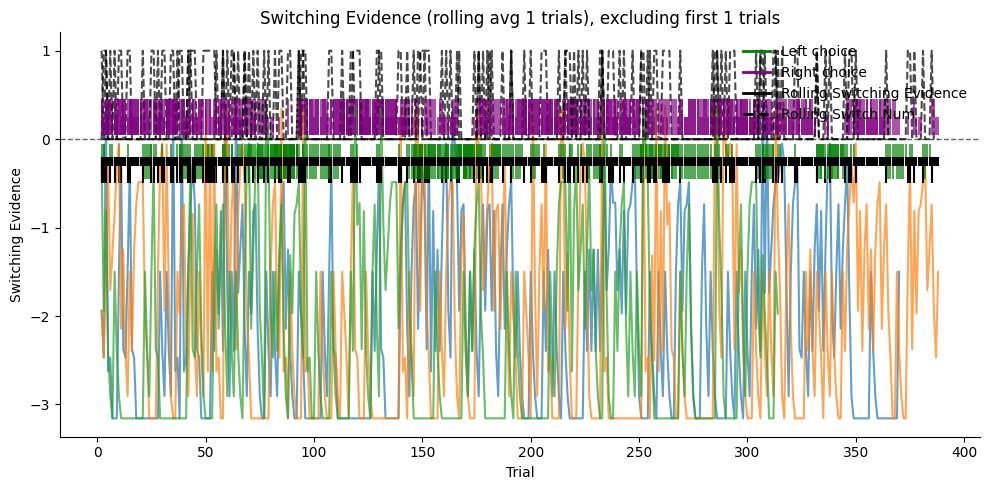

In [33]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Numero di trial da escludere all'inizio di ciascuna sessione
trial_to_exclude = 1

# Filtro dataframe
filtered_df = df_final_results[df_final_results['trial'] > trial_to_exclude].copy()

# Rolling average per switching evidence
window_size = 1
filtered_df['rolling_switching_evidence'] = filtered_df.groupby('session')['switching_evidence'].transform(
    lambda x: x.rolling(window=window_size, min_periods=1).mean()
)

# Rolling average per switch_num
filtered_df['rolling_switch_num'] = filtered_df.groupby('session')['switch_num'].transform(
    lambda x: x.rolling(window=window_size, min_periods=1).mean()
)

# Grafico
fig, ax = plt.subplots(figsize=(10, 5))

sessions = filtered_df['session'].unique()

for session in sessions:
    session_data = filtered_df[filtered_df['session'] == session]

    # Rolling average Switching Evidence
    ax.plot(session_data['trial'], session_data['rolling_switching_evidence'], 
            alpha=0.7, linewidth=1.5, label="Rolling Switching Evidence")

    # Rolling average Switch Num
    ax.plot(session_data['trial'], session_data['rolling_switch_num'], 
            color='black', linestyle='dashed', linewidth=1.5, alpha=0.7, label="Rolling Switch Num")

    # Trattini per scelte e risultati
    for idx, row in session_data.iterrows():
        trial = row['trial']
        choice = row['choice']
        outcome = row['outcome_bool']
        switch_num = row['switch_num']

        # Parametri trattini per scelta
        color = 'green' if choice == 'left' else 'purple'
        ypos = -0.05 if choice == 'left' else 0.05
        length = 0.4 if outcome == 1 else 0.2

        ax.vlines(trial, ypos, ypos + length if ypos > 0 else ypos - length,
                  color=color, linewidth=1.2, alpha=0.8)

        # Tick per switch_num
        tick_ypos = -0.2  # Posizione fissa sotto il grafico
        tick_length = 0.1 if switch_num == 0 else 0.3  # Tick corto per 0, lungo per 1

        ax.vlines(trial, tick_ypos, tick_ypos - tick_length, color='black', linewidth=1.5)

# Rimuove griglia e bordi
ax.grid(False)
ax.spines[['top', 'right']].set_visible(False)

# Linea orizzontale di riferimento
ax.axhline(0, linestyle='--', color='black', alpha=0.6, linewidth=1)

# Etichette
ax.set_xlabel('Trial')
ax.set_ylabel('Switching Evidence')
ax.set_title(f'Switching Evidence (rolling avg {window_size} trials), excluding first {trial_to_exclude} trials')

# Legenda aggiornata
custom_lines = [
    Line2D([0], [0], color='green', lw=2, label='Left choice'),
    Line2D([0], [0], color='purple', lw=2, label='Right choice'),
    Line2D([0], [0], color='black', lw=2, linestyle='-', label='Rolling Switching Evidence'),
    Line2D([0], [0], color='black', lw=2, linestyle='dashed', label='Rolling Switch Num')
]
ax.legend(handles=custom_lines, frameon=False, loc='upper right')

plt.tight_layout()
plt.show()


Min Switching Evidence: -3.157068148200466
Max Switching Evidence: 0.37678057589780856


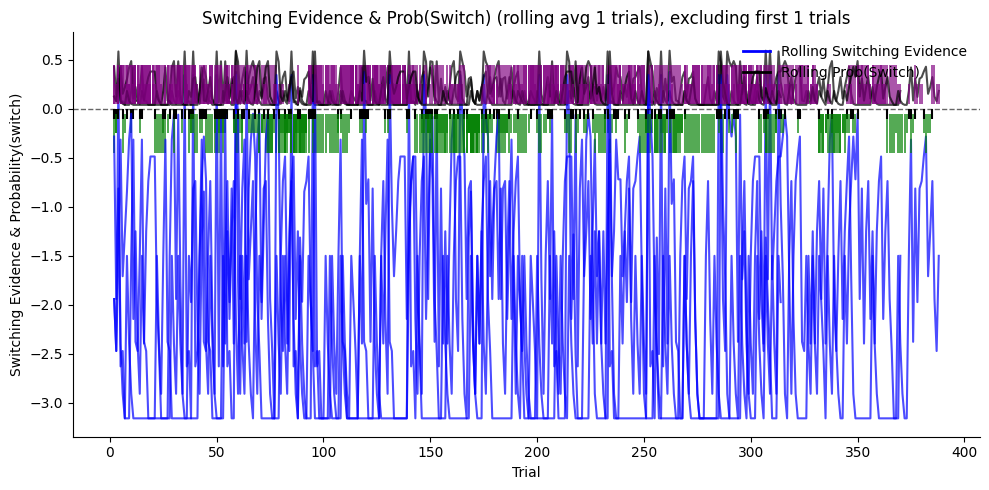

In [34]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Numero di trial da escludere all'inizio di ciascuna sessione
trial_to_exclude = 1

# Filtro dataframe per escludere primi trial
filtered_df = df_final_results[df_final_results['trial'] > trial_to_exclude].copy()

# 1. **Verifica della distribuzione di Switching Evidence**
print("Min Switching Evidence:", filtered_df['switching_evidence'].min())
print("Max Switching Evidence:", filtered_df['switching_evidence'].max())

# 2. **Calcolo della Probabilità di Switch con funzione logistica**
filtered_df['prob_switch'] = 1 / (1 + np.exp(-filtered_df['switching_evidence']))

# 3. **Rolling Average**
window_size = 1
filtered_df['rolling_switching_evidence'] = filtered_df.groupby('session')['switching_evidence'].transform(
    lambda x: x.rolling(window=window_size, min_periods=1).mean()
)

filtered_df['rolling_prob_switch'] = filtered_df.groupby('session')['prob_switch'].transform(
    lambda x: x.rolling(window=window_size, min_periods=1).mean()
)

# 4. **Plottiamo i risultati**
fig, ax = plt.subplots(figsize=(10, 5))

sessions = filtered_df['session'].unique()

for session in sessions:
    session_data = filtered_df[filtered_df['session'] == session]

    # Rolling average Switching Evidence
    ax.plot(session_data['trial'], session_data['rolling_switching_evidence'], 
            alpha=0.7, linewidth=1.5, label="Rolling Switching Evidence", color='blue') 

    # Rolling average Prob(Switch)
    ax.plot(session_data['trial'], session_data['rolling_prob_switch'], 
            color='black', linestyle='solid', linewidth=1.5, alpha=0.7, label="Rolling Prob(Switch)")
    
     # Trattini per scelte e risultati
    for idx, row in session_data.iterrows():
        trial = row['trial']
        choice = row['choice']
        outcome = row['outcome_bool']
        switch_num = row['switch_num']

        # Parametri trattini per scelta
        color = 'green' if choice == 'left' else 'purple'
        ypos = -0.05 if choice == 'left' else 0.05
        length = 0.4 if outcome == 1 else 0.2

        ax.vlines(trial, ypos, ypos + length if ypos > 0 else ypos - length,
                  color=color, linewidth=1.2, alpha=0.8)

        # Tick per switch_num
        tick_ypos = 0  # Posizione fissa sotto il grafico
        tick_length = 0.1 if switch_num == 1 else 0 # Tick corto per 0, lungo per 1

        ax.vlines(trial, tick_ypos, tick_ypos - tick_length, color='black', linewidth=1.5)

# Rimuove griglia e bordi
ax.grid(False)
ax.spines[['right', 'top']].set_visible(False)

# Linea orizzontale di riferimento
ax.axhline(0, linestyle='--', color='black', alpha=0.6, linewidth=1)

# Etichette
ax.set_xlabel('Trial')
ax.set_ylabel('Switching Evidence & Probability(switch)')
ax.set_title(f'Switching Evidence & Prob(Switch) (rolling avg {window_size} trials), excluding first {trial_to_exclude} trials')

# Legenda aggiornata
custom_lines = [
    Line2D([0], [0], color='blue', lw=2, label='Rolling Switching Evidence'),
    Line2D([0], [0], color='black', lw=2, linestyle='-', label='Rolling Prob(Switch)')
]
ax.legend(handles=custom_lines, frameon=False, loc='upper right')

plt.tight_layout()
plt.show()


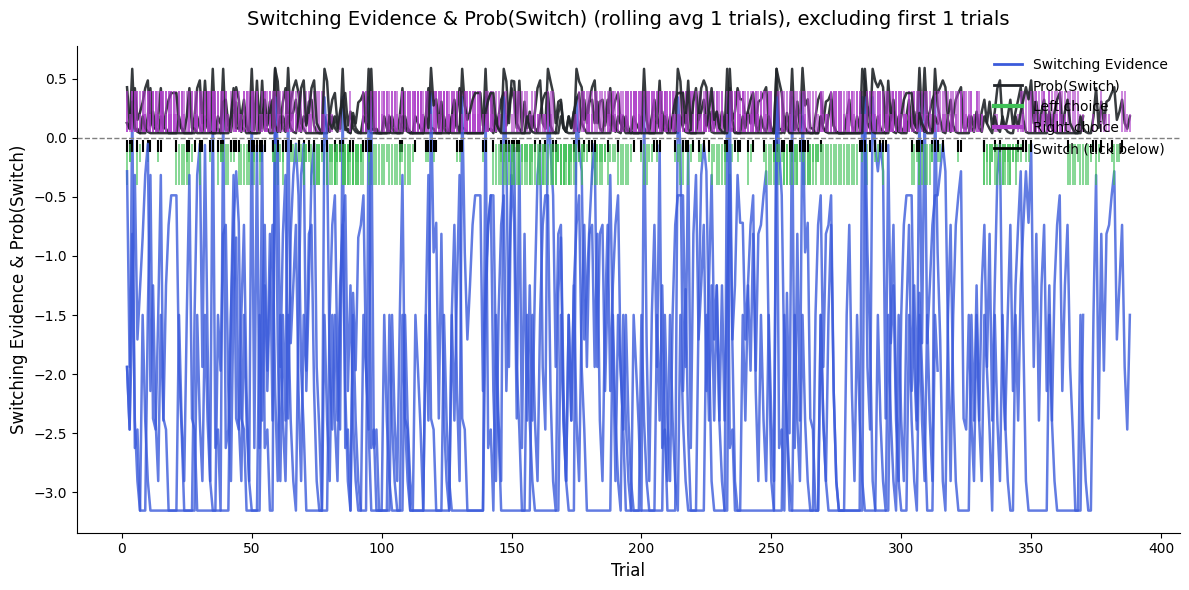

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Parametri
trial_to_exclude = 1
window_size = 1

# Filtro dei dati
filtered_df = df_final_results[df_final_results['trial'] > trial_to_exclude].copy()
filtered_df['prob_switch'] = 1 / (1 + np.exp(-filtered_df['switching_evidence']))

filtered_df['rolling_switching_evidence'] = filtered_df.groupby('session')['switching_evidence'].transform(
    lambda x: x.rolling(window=window_size, min_periods=1).mean()
)
filtered_df['rolling_prob_switch'] = filtered_df.groupby('session')['prob_switch'].transform(
    lambda x: x.rolling(window=window_size, min_periods=1).mean()
)

# --- Plot migliorato ---
fig, ax = plt.subplots(figsize=(12, 6))
sessions = filtered_df['session'].unique()

for session in sessions:
    session_data = filtered_df[filtered_df['session'] == session]

    # Linee continue
    ax.plot(session_data['trial'], session_data['rolling_switching_evidence'], 
            alpha=0.8, linewidth=1.8, label='Switching Evidence', color='#3b5bdb')

    ax.plot(session_data['trial'], session_data['rolling_prob_switch'], 
            color='#212529', linestyle='-', linewidth=1.8, alpha=0.9, label='Prob(Switch)')

    # Ticks per scelta
    for idx, row in session_data.iterrows():
        trial = row['trial']
        choice = row['choice']
        outcome = row['outcome_bool']
        switch_num = row['switch_num']

        color = '#40c057' if choice == 'left' else '#ae3ec9'  # verde chiaro / viola
        ypos = -0.05 if choice == 'left' else 0.05
        length = 0.35 if outcome == 1 else 0.15

        ax.vlines(trial, ypos, ypos + length if ypos > 0 else ypos - length,
                  color=color, linewidth=1.1, alpha=0.8)

        # Tick per switch
        if switch_num == 1:
            ax.vlines(trial, -0.02, -0.12, color='black', linewidth=1.5)

# Styling generale
ax.axhline(0, linestyle='--', color='gray', linewidth=1)
ax.set_xlabel('Trial', fontsize=12)
ax.set_ylabel('Switching Evidence & Prob(Switch)', fontsize=12)
ax.set_title(f'Switching Evidence & Prob(Switch) (rolling avg {window_size} trials), excluding first {trial_to_exclude} trials',
             fontsize=14, pad=15)

# Rimuove bordi/griglia superflui
ax.spines[['right', 'top']].set_visible(False)
ax.grid(False)

# Legenda pulita
custom_lines = [
    Line2D([0], [0], color='#3b5bdb', lw=2, label='Switching Evidence'),
    Line2D([0], [0], color='#212529', lw=2, label='Prob(Switch)'),
    Line2D([0], [0], color='#40c057', lw=3, label='Left choice'),
    Line2D([0], [0], color='#ae3ec9', lw=3, label='Right choice'),
    Line2D([0], [0], color='black', lw=2, label='Switch (tick below)')
]
ax.legend(handles=custom_lines, frameon=False, fontsize=10, loc='upper right')

plt.tight_layout()
plt.show()


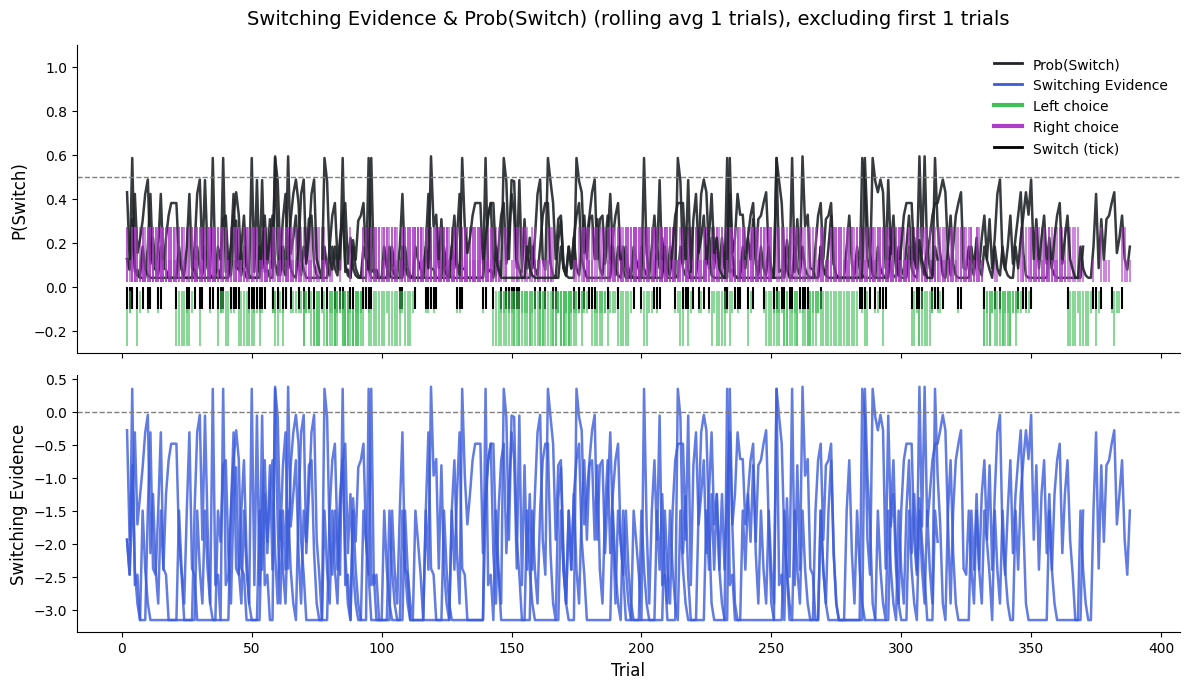

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Parametri
trial_to_exclude = 1
window_size = 1

# Preprocessing
filtered_df = df_final_results[df_final_results['trial'] > trial_to_exclude].copy()
filtered_df['prob_switch'] = 1 / (1 + np.exp(-filtered_df['switching_evidence']))

filtered_df['rolling_switching_evidence'] = filtered_df.groupby('session')['switching_evidence'].transform(
    lambda x: x.rolling(window=window_size, min_periods=1).mean()
)
filtered_df['rolling_prob_switch'] = filtered_df.groupby('session')['prob_switch'].transform(
    lambda x: x.rolling(window=window_size, min_periods=1).mean()
)

# === Plot ===
fig, (ax_top, ax_bottom) = plt.subplots(2, 1, figsize=(12, 7), sharex=True, gridspec_kw={'height_ratios': [1.2, 1]})
sessions = filtered_df['session'].unique()

for session in sessions:
    session_data = filtered_df[filtered_df['session'] == session]

    # --- Top: Probabilità di switch + ticks ---
    ax_top.plot(session_data['trial'], session_data['rolling_prob_switch'],
                color='#212529', linestyle='-', linewidth=1.8, alpha=0.9, label='Prob(Switch)')

    for idx, row in session_data.iterrows():
        trial = row['trial']
        choice = row['choice']
        outcome = row['outcome_bool']
        switch_num = row['switch_num']

        color = '#40c057' if choice == 'left' else '#ae3ec9'
        ypos = 0.02 if choice == 'right' else -0.02
        length = 0.25 if outcome == 1 else 0.1

        ax_top.vlines(trial, ypos, ypos + length if ypos > 0 else ypos - length,
                      color=color, linewidth=1.1, alpha=0.8)

        if switch_num == 1:
            ax_top.vlines(trial, 0.0, -0.1, color='black', linewidth=1.5)

    # --- Bottom: Switching Evidence ---
    ax_bottom.plot(session_data['trial'], session_data['rolling_switching_evidence'],
                   alpha=0.8, linewidth=1.8, color='#3b5bdb', label='Switching Evidence')

# --- Styling assi superiori ---
ax_top.set_ylabel('P(Switch)', fontsize=12)
ax_top.set_ylim(-0.3, 1.1)
ax_top.spines[['right', 'top']].set_visible(False)
ax_top.axhline(0.5, linestyle='--', color='gray', linewidth=1)
ax_top.set_title(f'Switching Evidence & Prob(Switch) (rolling avg {window_size} trials), excluding first {trial_to_exclude} trials',
                 fontsize=14, pad=15)

# --- Styling asse inferiore ---
ax_bottom.set_ylabel('Switching Evidence', fontsize=12)
ax_bottom.set_xlabel('Trial', fontsize=12)
ax_bottom.axhline(0, linestyle='--', color='gray', linewidth=1)
ax_bottom.spines[['right', 'top']].set_visible(False)

# Legenda compatta sopra
custom_lines = [
    Line2D([0], [0], color='#212529', lw=2, label='Prob(Switch)'),
    Line2D([0], [0], color='#3b5bdb', lw=2, label='Switching Evidence'),
    Line2D([0], [0], color='#40c057', lw=3, label='Left choice'),
    Line2D([0], [0], color='#ae3ec9', lw=3, label='Right choice'),
    Line2D([0], [0], color='black', lw=2, label='Switch (tick)')
]
ax_top.legend(handles=custom_lines, frameon=False, fontsize=10, loc='upper right')

plt.tight_layout()
plt.show()


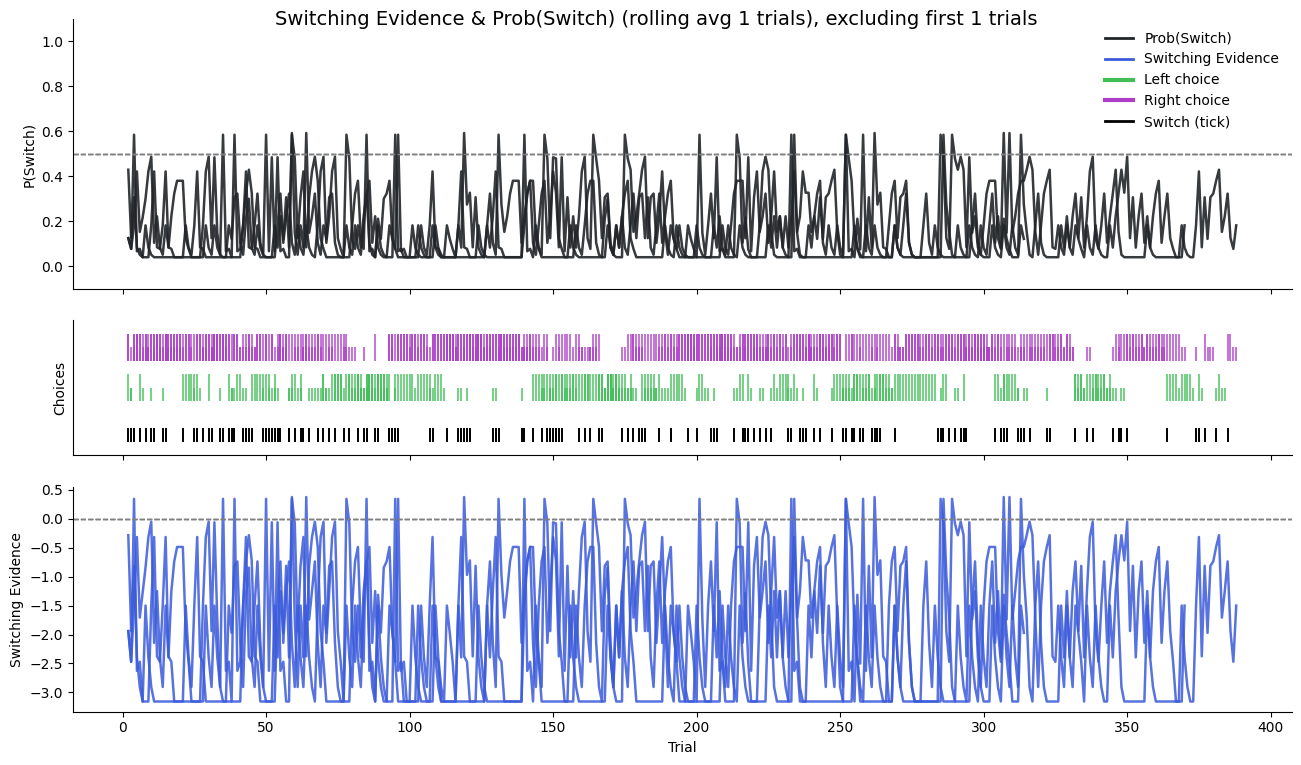

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Parametri
trial_to_exclude = 1
window_size = 1

# Preprocessing
filtered_df = df_final_results[df_final_results['trial'] > trial_to_exclude].copy()
filtered_df['prob_switch'] = 1 / (1 + np.exp(-filtered_df['switching_evidence']))

filtered_df['rolling_switching_evidence'] = filtered_df.groupby('session')['switching_evidence'].transform(
    lambda x: x.rolling(window=window_size, min_periods=1).mean()
)
filtered_df['rolling_prob_switch'] = filtered_df.groupby('session')['prob_switch'].transform(
    lambda x: x.rolling(window=window_size, min_periods=1).mean()
)

# === 3 Assi verticali ===
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(13, 8), sharex=True,
                                    gridspec_kw={'height_ratios': [1.2, 0.6, 1]})

sessions = filtered_df['session'].unique()

for session in sessions:
    session_data = filtered_df[filtered_df['session'] == session]

    # ---- AX1: Prob(Switch) ----
    ax1.plot(session_data['trial'], session_data['rolling_prob_switch'],
             color='#212529', linestyle='-', linewidth=1.8, alpha=0.9, label='Prob(Switch)')
    ax1.axhline(0.5, linestyle='--', color='gray', linewidth=1)
    ax1.set_ylabel('P(Switch)')
    ax1.set_ylim(-0.1, 1.1)
    ax1.spines[['right', 'top']].set_visible(False)

    # ---- AX2: Ticks (choice & switch) ----
    for idx, row in session_data.iterrows():
        trial = row['trial']
        choice = row['choice']
        outcome = row['outcome_bool']
        switch_num = row['switch_num']

        color = '#40c057' if choice == 'left' else '#ae3ec9'
        ypos = 0.0 if choice == 'left' else 0.3
        length = 0.2 if outcome == 1 else 0.1

        ax2.vlines(trial, ypos, ypos + length, color=color, linewidth=1.2, alpha=0.85)

        # Tick per switch
        if switch_num == 1:
            ax2.vlines(trial, -0.2, -0.3, color='black', linewidth=1.4)

    ax2.set_ylim(-0.4, 0.6)
    ax2.set_yticks([])
    ax2.set_ylabel('Choices')
    ax2.spines[['right', 'top']].set_visible(False)

    # ---- AX3: Switching Evidence ----
    ax3.plot(session_data['trial'], session_data['rolling_switching_evidence'],
             alpha=0.85, linewidth=1.8, color='#3b5bdb', label='Switching Evidence')
    ax3.axhline(0, linestyle='--', color='gray', linewidth=1)
    ax3.set_ylabel('Switching Evidence')
    ax3.set_xlabel('Trial')
    ax3.spines[['right', 'top']].set_visible(False)

# Titolo globale
fig.suptitle(f'Switching Evidence & Prob(Switch) (rolling avg {window_size} trials), excluding first {trial_to_exclude} trials',
             fontsize=14, y=0.95)

# Legenda (solo nel primo asse)
custom_lines = [
    Line2D([0], [0], color='#212529', lw=2, label='Prob(Switch)'),
    Line2D([0], [0], color='#3b5bdb', lw=2, label='Switching Evidence'),
    Line2D([0], [0], color='#40c057', lw=3, label='Left choice'),
    Line2D([0], [0], color='#ae3ec9', lw=3, label='Right choice'),
    Line2D([0], [0], color='black', lw=2, label='Switch (tick)')
]
ax1.legend(handles=custom_lines, frameon=False, fontsize=10, loc='upper right')

plt.tight_layout()
plt.subplots_adjust(hspace=0.15)
plt.show()


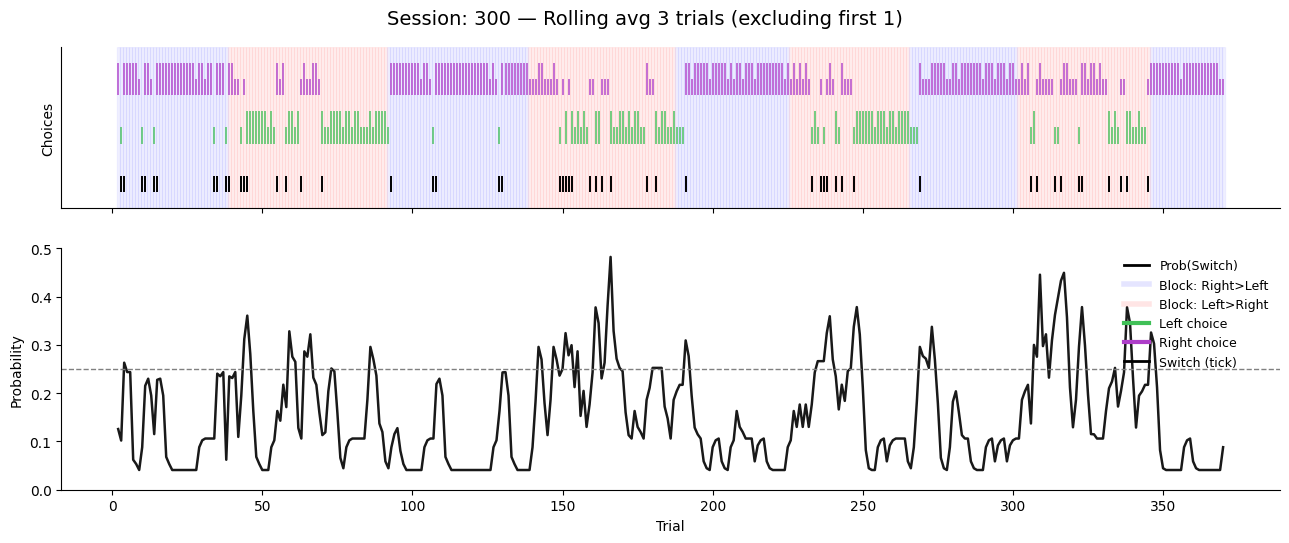

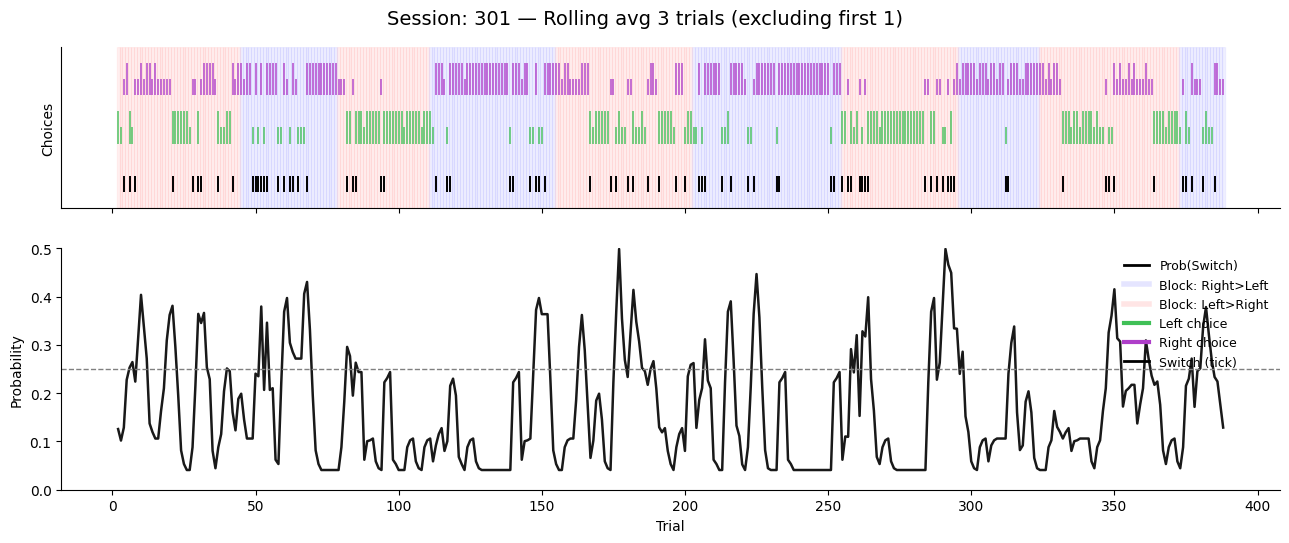

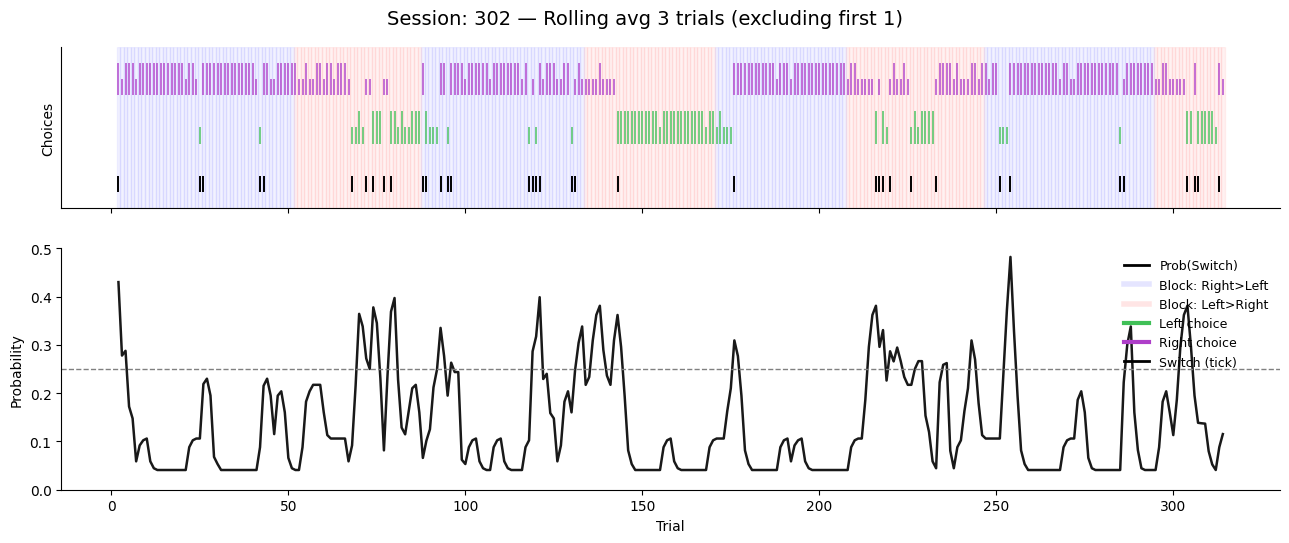

In [38]:
# Codice aggiornato con tutte le modifiche richieste

def plot_switching_evidence_summary_v2(df, trial_to_exclude=1, window_size=1, max_sessions=3):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D

    filtered_df = df[df['trial'] > trial_to_exclude].copy()
    filtered_df['prob_switch'] = 1 / (1 + np.exp(-filtered_df['switching_evidence']))
    
    filtered_df['rolling_prob_switch'] = filtered_df.groupby('session')['prob_switch'].transform(
        lambda x: x.rolling(window=window_size, min_periods=1).mean()
    )

    sessions = filtered_df['session'].unique()[:max_sessions]

    for session in sessions:
        session_data = filtered_df[filtered_df['session'] == session]

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 5.5), sharex=True,
                                        gridspec_kw={'height_ratios': [0.8, 1.2]})

        # --- AX1: Raster plot con sfondo blocchi
        for idx, row in session_data.iterrows():
            trial = row['trial']
            prob_r = row['probability_r'] if 'probability_r' in row else np.nan

            if not np.isnan(prob_r):
                if prob_r > 0.5:
                    ax1.axvspan(trial - 0.5, trial + 0.5, color='blue', alpha=0.05)
                elif prob_r < 0.5:
                    ax1.axvspan(trial - 0.5, trial + 0.5, color='red', alpha=0.05)

        for idx, row in session_data.iterrows():
            trial = row['trial']
            choice = row['choice']
            outcome = row['outcome_bool']
            switch_num = row['switch_num']

            color = '#40c057' if choice == 'left' else '#ae3ec9'
            ypos = 0.0 if choice == 'left' else 0.3
            length = 0.2 if outcome == 1 else 0.1
            ax1.vlines(trial, ypos, ypos + length, color=color, linewidth=1.2, alpha=0.85)

            if switch_num == 1:
                ax1.vlines(trial, -0.2, -0.3, color='black', linewidth=1.4)

        ax1.set_ylim(-0.4, 0.6)
        ax1.set_yticks([])
        ax1.set_ylabel('Choices')
        ax1.spines['right'].set_visible(False)
        ax1.spines['top'].set_visible(False)

        # --- AX2: Prob(switch)
        ax2.plot(session_data['trial'], session_data['rolling_prob_switch'],
                 color='black', linestyle='-', linewidth=1.8, alpha=0.9, label='Prob(Switch)')

        ax2.set_ylabel('Probability')
        ax2.set_xlabel('Trial')
        ax2.set_ylim(0, 0.5)
        ax2.axhline(0.25, linestyle='--', color='gray', linewidth=1)
        ax2.spines['right'].set_visible(False)
        ax2.spines['top'].set_visible(False)

        # Legenda
        custom_lines = [
            Line2D([0], [0], color='black', lw=2, label='Prob(Switch)'),
            Line2D([0], [0], color='blue', lw=4, alpha=0.1, label='Block: Right>Left'),
            Line2D([0], [0], color='red', lw=4, alpha=0.1, label='Block: Left>Right'),
            Line2D([0], [0], color='#40c057', lw=3, label='Left choice'),
            Line2D([0], [0], color='#ae3ec9', lw=3, label='Right choice'),
            Line2D([0], [0], color='black', lw=2, label='Switch (tick)')
        ]
        ax2.legend(handles=custom_lines, frameon=False, fontsize=9, loc='upper right')

        fig.suptitle(f'Session: {session} — Rolling avg {window_size} trials (excluding first {trial_to_exclude})',
                     fontsize=14, y=0.98)
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.2)
        plt.show()


plot_switching_evidence_summary_v2(df_final_results, trial_to_exclude=1, window_size=3)


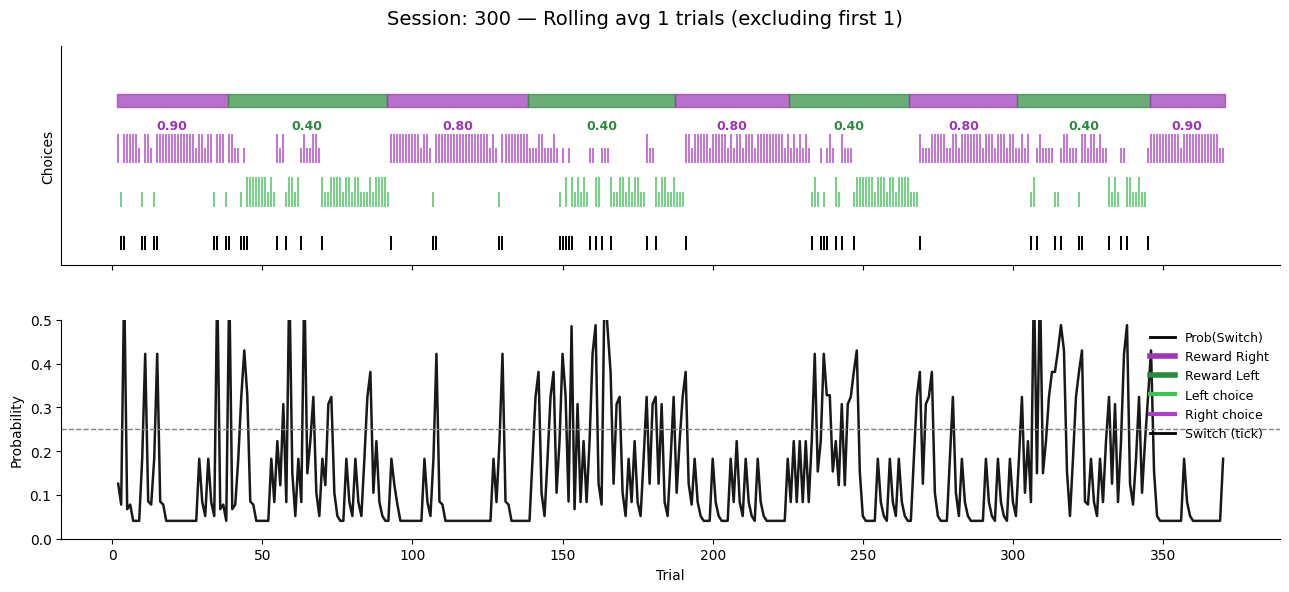

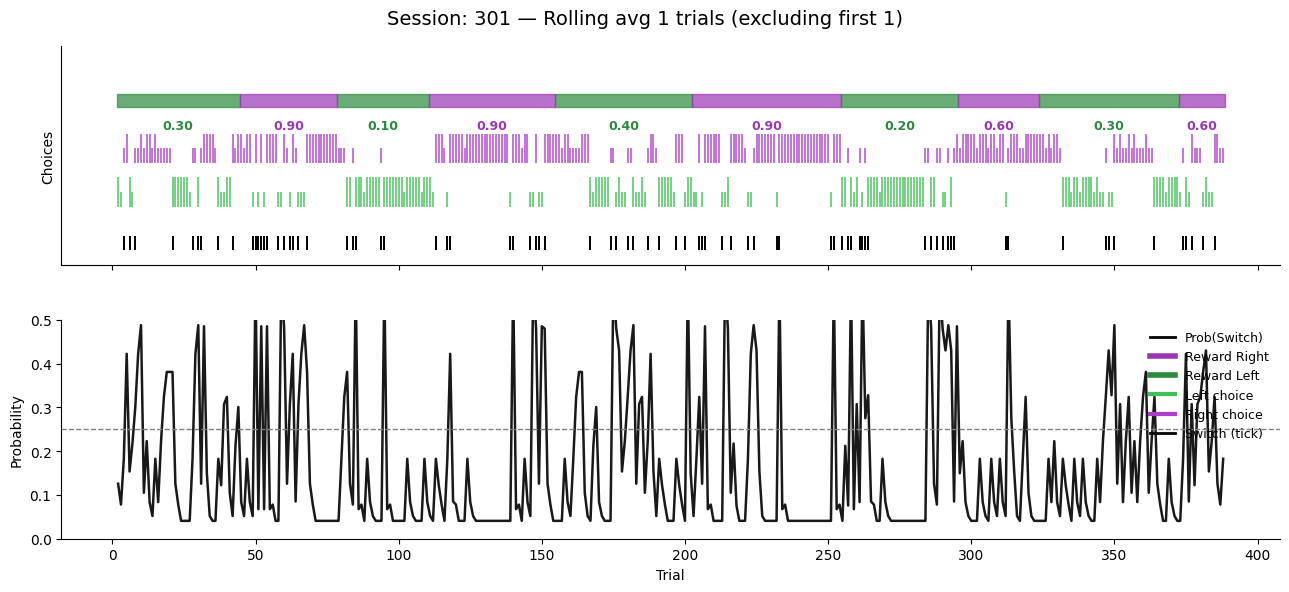

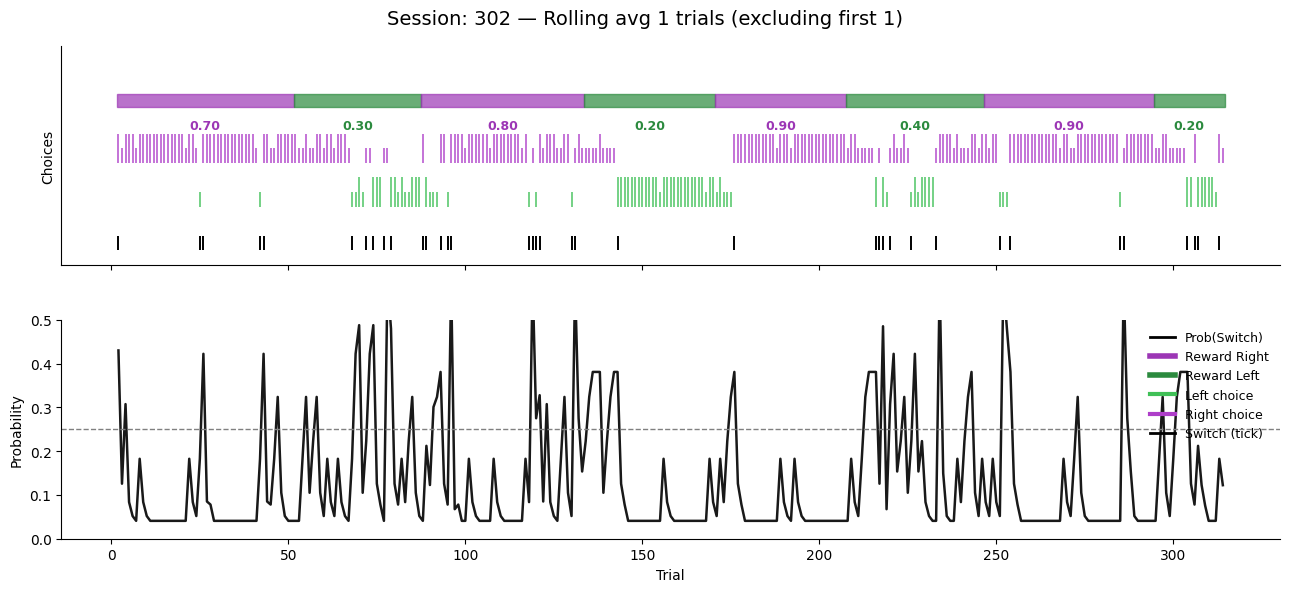

In [39]:
def plot_switching_evidence_summary_v4(df, trial_to_exclude=1, window_size=1, max_sessions=3):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D

    filtered_df = df[df['trial'] > trial_to_exclude].copy()
    filtered_df['prob_switch'] = 1 / (1 + np.exp(-filtered_df['switching_evidence']))

    filtered_df['rolling_prob_switch'] = filtered_df.groupby('session')['prob_switch'].transform(
        lambda x: x.rolling(window=window_size, min_periods=1).mean()
    )

    sessions = filtered_df['session'].unique()[:max_sessions]

    for session in sessions:
        session_data = filtered_df[filtered_df['session'] == session].copy()

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 6), sharex=True,
                                        gridspec_kw={'height_ratios': [1.2, 1.2]})

        # === BLOCCHI PROBABILITY_R ===
        if 'probability_r' in session_data.columns:
            prob_r_values = session_data['probability_r'].values
            trials = session_data['trial'].values

            block_starts = [0]
            for i in range(1, len(prob_r_values)):
                if prob_r_values[i] != prob_r_values[i - 1]:
                    block_starts.append(i)
            block_starts.append(len(prob_r_values))

            for i in range(len(block_starts) - 1):
                start_idx = block_starts[i]
                end_idx = block_starts[i + 1]

                start_trial = trials[start_idx] - 0.5
                end_trial = trials[end_idx - 1] + 0.5
                prob = prob_r_values[start_idx]
                center_trial = (start_trial + end_trial) / 2

                # ⚠️ Inversione colori: viola = right, verde = left
                color = '#9c36b5' if prob > 0.5 else '#2b8a3e'
                ax1.axvspan(start_trial, end_trial, ymin=0.72, ymax=0.78, color=color, alpha=0.7)

                ax1.text(center_trial, 0.60, f'{prob:.2f}', color=color,
                         fontsize=9, ha='center', va='top', fontweight='bold')

        # === RASTER PLOT ===
        for idx, row in session_data.iterrows():
            trial = row['trial']
            choice = row['choice']
            outcome = row['outcome_bool']
            switch_num = row['switch_num']

            color = '#40c057' if choice == 'left' else '#ae3ec9'
            ypos = 0.0 if choice == 'left' else 0.3
            length = 0.2 if outcome == 1 else 0.1
            ax1.vlines(trial, ypos, ypos + length, color=color, linewidth=1.2, alpha=0.85)

            if switch_num == 1:
                ax1.vlines(trial, -0.2, -0.3, color='black', linewidth=1.4)

        ax1.set_ylim(-0.4, 1.1)
        ax1.set_yticks([])
        ax1.set_ylabel('Choices')
        ax1.spines['right'].set_visible(False)
        ax1.spines['top'].set_visible(False)

        # === PROB(SWITCH) ===
        ax2.plot(session_data['trial'], session_data['rolling_prob_switch'],
                 color='black', linestyle='-', linewidth=1.8, alpha=0.9, label='Prob(Switch)')

        ax2.set_ylabel('Probability')
        ax2.set_xlabel('Trial')
        ax2.set_ylim(0, 0.5)
        ax2.axhline(0.25, linestyle='--', color='gray', linewidth=1)
        ax2.spines['right'].set_visible(False)
        ax2.spines['top'].set_visible(False)

        # === LEGENDA ===
        custom_lines = [
            Line2D([0], [0], color='black', lw=2, label='Prob(Switch)'),
            Line2D([0], [0], color='#9c36b5', lw=4, label='Reward Right'),
            Line2D([0], [0], color='#2b8a3e', lw=4, label='Reward Left'),
            Line2D([0], [0], color='#40c057', lw=3, label='Left choice'),
            Line2D([0], [0], color='#ae3ec9', lw=3, label='Right choice'),
            Line2D([0], [0], color='black', lw=2, label='Switch (tick)')
        ]
        ax2.legend(handles=custom_lines, frameon=False, fontsize=9, loc='upper right')

        fig.suptitle(f'Session: {session} — Rolling avg {window_size} trials (excluding first {trial_to_exclude})',
                     fontsize=14, y=0.98)
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.25)
        plt.show()
plot_switching_evidence_summary_v4(df_final_results, trial_to_exclude=1, window_size=1)



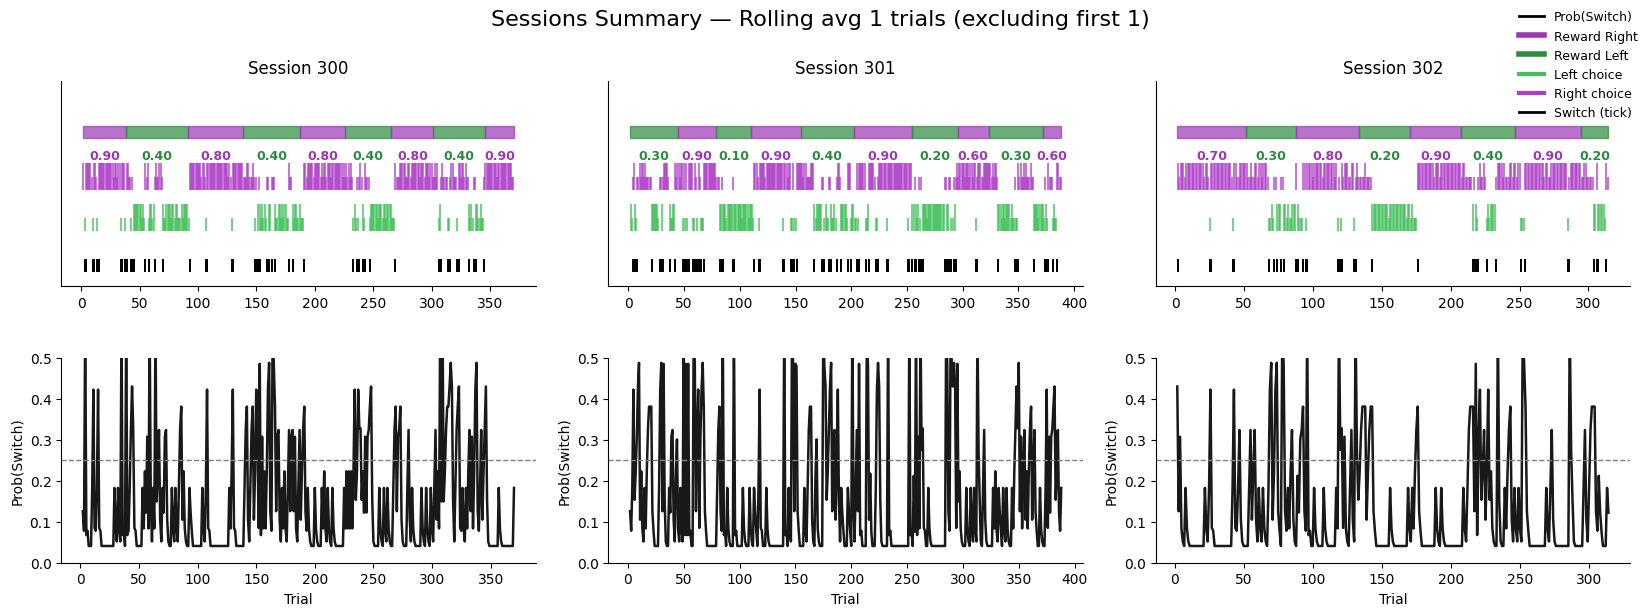

In [41]:
def plot_sessions_in_columns(df, session_list, trial_to_exclude=1, window_size=1):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D

    filtered_df = df[df['trial'] > trial_to_exclude].copy()
    filtered_df['prob_switch'] = 1 / (1 + np.exp(-filtered_df['switching_evidence']))
    filtered_df['rolling_prob_switch'] = filtered_df.groupby('session')['prob_switch'].transform(
        lambda x: x.rolling(window=window_size, min_periods=1).mean()
    )

    n_sessions = len(session_list)
    fig, axes = plt.subplots(2, n_sessions, figsize=(5.5 * n_sessions, 6), sharex=False)

    if n_sessions == 1:
        axes = np.array([[axes[0]], [axes[1]]])  # Per gestire anche il caso 1x1

    for idx, session in enumerate(session_list):
        session_data = filtered_df[filtered_df['session'] == session].copy()
        ax1 = axes[0, idx]
        ax2 = axes[1, idx]

        # === BLOCCHI PROBABILITY_R ===
        if 'probability_r' in session_data.columns:
            prob_r_values = session_data['probability_r'].values
            trials = session_data['trial'].values

            block_starts = [0]
            for j in range(1, len(prob_r_values)):
                if prob_r_values[j] != prob_r_values[j - 1]:
                    block_starts.append(j)
            block_starts.append(len(prob_r_values))

            for j in range(len(block_starts) - 1):
                start_idx = block_starts[j]
                end_idx = block_starts[j + 1]

                start_trial = trials[start_idx] - 0.5
                end_trial = trials[end_idx - 1] + 0.5
                prob = prob_r_values[start_idx]
                center_trial = (start_trial + end_trial) / 2

                color = '#9c36b5' if prob > 0.5 else '#2b8a3e'
                ax1.axvspan(start_trial, end_trial, ymin=0.72, ymax=0.78, color=color, alpha=0.7)
                ax1.text(center_trial, 0.60, f'{prob:.2f}', color=color,
                         fontsize=9, ha='center', va='top', fontweight='bold')

        # === RASTER PLOT ===
        for _, row in session_data.iterrows():
            trial = row['trial']
            choice = row['choice']
            outcome = row['outcome_bool']
            switch_num = row['switch_num']

            color = '#40c057' if choice == 'left' else '#ae3ec9'
            ypos = 0.0 if choice == 'left' else 0.3
            length = 0.2 if outcome == 1 else 0.1
            ax1.vlines(trial, ypos, ypos + length, color=color, linewidth=1.2, alpha=0.85)
            if switch_num == 1:
                ax1.vlines(trial, -0.2, -0.3, color='black', linewidth=1.4)

        ax1.set_ylim(-0.4, 1.1)
        ax1.set_yticks([])
        ax1.set_title(f'Session {session}', fontsize=12)
        ax1.spines['right'].set_visible(False)
        ax1.spines['top'].set_visible(False)

        # === PROB SWITCH ===
        ax2.plot(session_data['trial'], session_data['rolling_prob_switch'],
                 color='black', linestyle='-', linewidth=1.8, alpha=0.9)

        ax2.set_ylabel('Prob(Switch)')
        ax2.set_xlabel('Trial')
        ax2.set_ylim(0, 0.5)
        ax2.axhline(0.25, linestyle='--', color='gray', linewidth=1)
        ax2.spines['right'].set_visible(False)
        ax2.spines['top'].set_visible(False)

    # === LEGENDA comune ===
    custom_lines = [
        Line2D([0], [0], color='black', lw=2, label='Prob(Switch)'),
        Line2D([0], [0], color='#9c36b5', lw=4, label='Reward Right'),
        Line2D([0], [0], color='#2b8a3e', lw=4, label='Reward Left'),
        Line2D([0], [0], color='#40c057', lw=3, label='Left choice'),
        Line2D([0], [0], color='#ae3ec9', lw=3, label='Right choice'),
        Line2D([0], [0], color='black', lw=2, label='Switch (tick)')
    ]
    fig.legend(handles=custom_lines, frameon=False, fontsize=9, loc='upper right')

    fig.suptitle(f'Sessions Summary — Rolling avg {window_size} trials (excluding first {trial_to_exclude})',
                 fontsize=16, y=1.02)
    plt.tight_layout()
    plt.subplots_adjust(top=0.90, hspace=0.35)
    plt.show()

target_sessions = [300, 301, 302]
plot_sessions_in_columns(df_final_results, session_list=target_sessions, window_size=1)

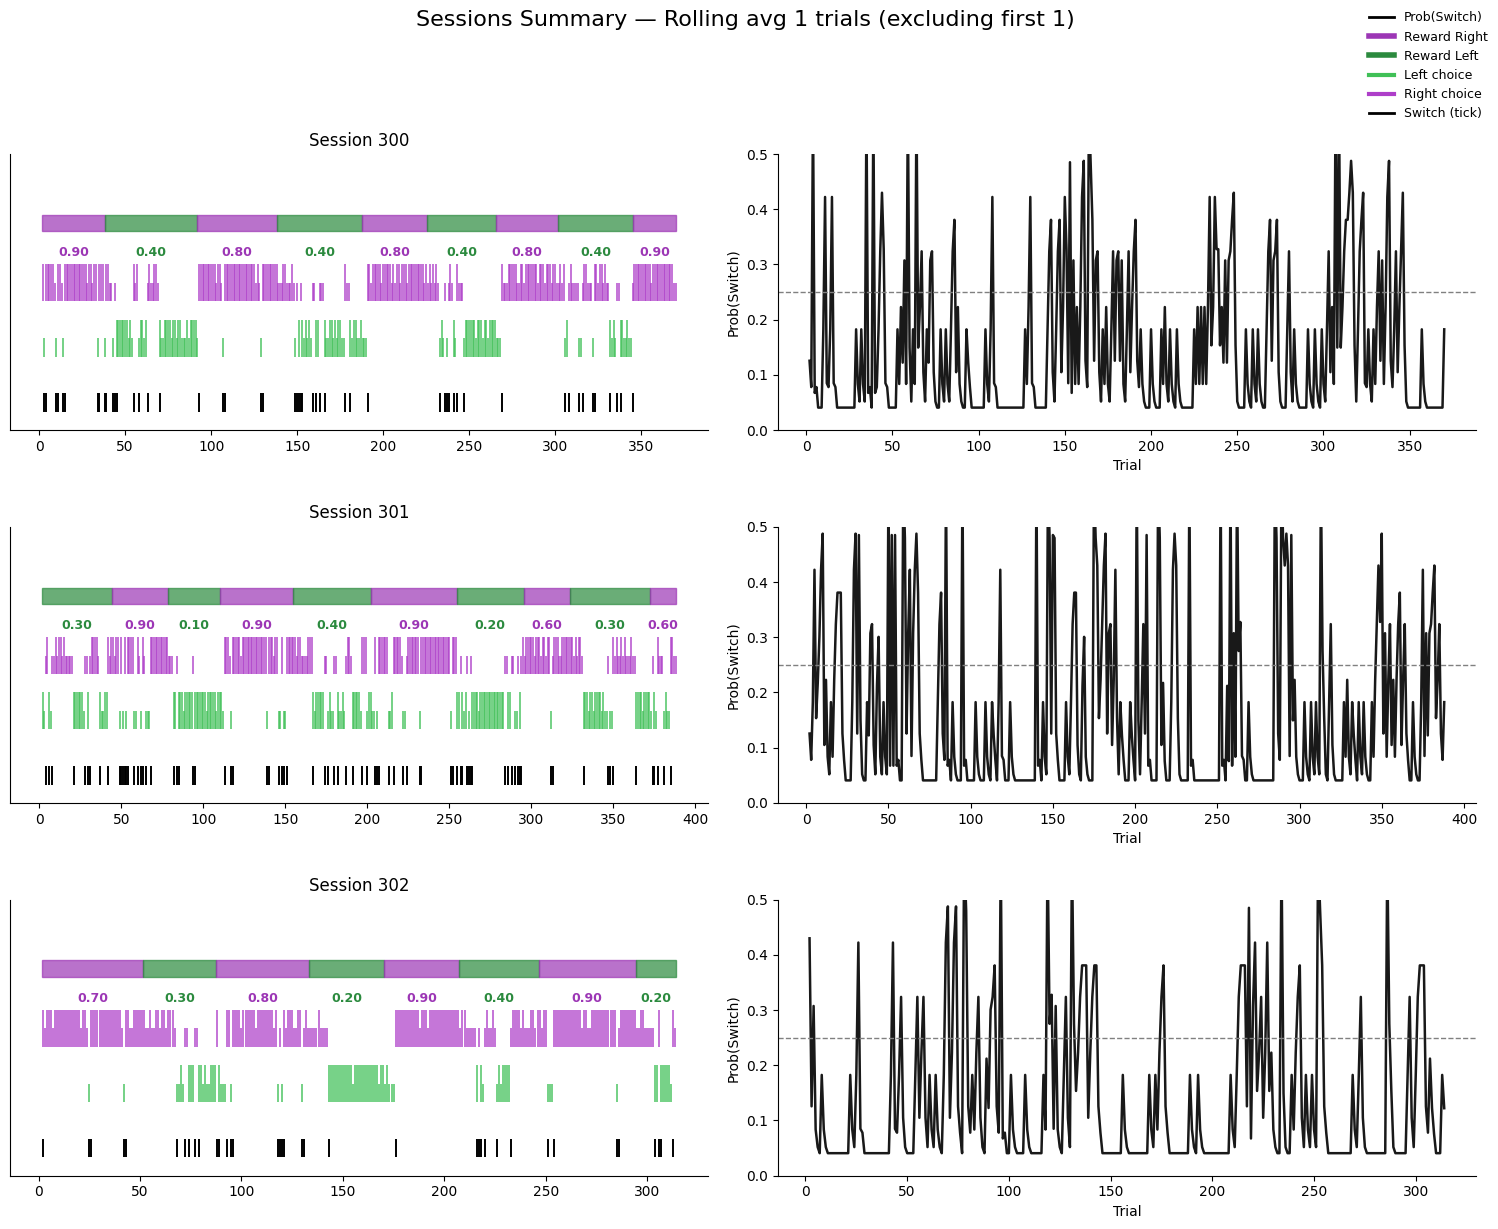

In [46]:
def plot_sessions_in_columns(df, session_list, trial_to_exclude=1, window_size=1):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D

    filtered_df = df[df['trial'] > trial_to_exclude].copy()
    filtered_df['prob_switch'] = 1 / (1 + np.exp(-filtered_df['switching_evidence']))
    filtered_df['rolling_prob_switch'] = filtered_df.groupby('session')['prob_switch'].transform(
        lambda x: x.rolling(window=window_size, min_periods=1).mean()
    )

    n_sessions = len(session_list)
    fig, axes = plt.subplots(n_sessions, 2, figsize=(15, 4 * n_sessions), sharex=False)  # 1 col, n_sessions rows

    for idx, session in enumerate(session_list):
        session_data = filtered_df[filtered_df['session'] == session].copy()
        ax1 = axes[idx, 0]  # Primo grafico (Rasters)
        ax2 = axes[idx, 1]  # Secondo grafico (Prob Switch)

        # === BLOCCHI PROBABILITY_R ===
        if 'probability_r' in session_data.columns:
            prob_r_values = session_data['probability_r'].values
            trials = session_data['trial'].values

            block_starts = [0]
            for j in range(1, len(prob_r_values)):
                if prob_r_values[j] != prob_r_values[j - 1]:
                    block_starts.append(j)
            block_starts.append(len(prob_r_values))

            for j in range(len(block_starts) - 1):
                start_idx = block_starts[j]
                end_idx = block_starts[j + 1]

                start_trial = trials[start_idx] - 0.5
                end_trial = trials[end_idx - 1] + 0.5
                prob = prob_r_values[start_idx]
                center_trial = (start_trial + end_trial) / 2

                color = '#9c36b5' if prob > 0.5 else '#2b8a3e'
                ax1.axvspan(start_trial, end_trial, ymin=0.72, ymax=0.78, color=color, alpha=0.7)
                ax1.text(center_trial, 0.60, f'{prob:.2f}', color=color,
                         fontsize=9, ha='center', va='top', fontweight='bold')

        # === RASTER PLOT ===
        for _, row in session_data.iterrows():
            trial = row['trial']
            choice = row['choice']
            outcome = row['outcome_bool']
            switch_num = row['switch_num']

            color = '#40c057' if choice == 'left' else '#ae3ec9'
            ypos = 0.0 if choice == 'left' else 0.3
            length = 0.2 if outcome == 1 else 0.1
            ax1.vlines(trial, ypos, ypos + length, color=color, linewidth=1.2, alpha=0.85)
            if switch_num == 1:
                ax1.vlines(trial, -0.2, -0.3, color='black', linewidth=1.4)

        ax1.set_ylim(-0.4, 1.1)
        ax1.set_yticks([])
        ax1.set_title(f'Session {session}', fontsize=12)
        ax1.spines['right'].set_visible(False)
        ax1.spines['top'].set_visible(False)

        # === PROB SWITCH ===
        ax2.plot(session_data['trial'], session_data['rolling_prob_switch'],
                 color='black', linestyle='-', linewidth=1.8, alpha=0.9)

        ax2.set_ylabel('Prob(Switch)')
        ax2.set_xlabel('Trial')
        ax2.set_ylim(0, 0.5)
        ax2.axhline(0.25, linestyle='--', color='gray', linewidth=1)
        ax2.spines['right'].set_visible(False)
        ax2.spines['top'].set_visible(False)

    # === LEGENDA comune ===
    custom_lines = [
        Line2D([0], [0], color='black', lw=2, label='Prob(Switch)'),
        Line2D([0], [0], color='#9c36b5', lw=4, label='Reward Right'),
        Line2D([0], [0], color='#2b8a3e', lw=4, label='Reward Left'),
        Line2D([0], [0], color='#40c057', lw=3, label='Left choice'),
        Line2D([0], [0], color='#ae3ec9', lw=3, label='Right choice'),
        Line2D([0], [0], color='black', lw=2, label='Switch (tick)')
    ]
    fig.legend(handles=custom_lines, frameon=False, fontsize=9, loc='upper right')

    fig.suptitle(f'Sessions Summary — Rolling avg {window_size} trials (excluding first {trial_to_exclude})',
                 fontsize=16, y=1.02)
    plt.tight_layout()
    plt.subplots_adjust(top=0.90, hspace=0.35)
    plt.show()



target_sessions = [300, 301, 302]  # Sostituisci con le sessioni che desideri visualizzare
plot_sessions_in_columns(df_final_results, session_list=target_sessions, window_size=1)

In [ ]:
df_final_results.head(1000)

,session,trial,task,outcome,side,iti_duration,probability_r,outcome_bool,choice,r_plus,...,rss_plus2,rss_minus2,rds_plus2,outcome_bool_3,choice_3,rss_plus3,rss_minus3,rds_plus3,intercept,switching_evidence
0,300,1,S4_5,correct,right,1.245809,0.9,1,right,1.0,...,0,0,0,NaN,NaN,0,0,0,-0.282327,NaN
1,300,2,S4_5,correct,right,3.716877,0.9,1,right,1.0,...,0,0,0,NaN,NaN,0,0,0,-0.282327,-1.940125
2,300,3,S4_5,incorrect,right,2.723236,0.9,0,left,0.0,...,1,0,0,NaN,NaN,0,0,0,-0.282327,-2.470243
3,300,4,S4_5,correct,right,0.847408,0.9,1,right,1.0,...,0,0,1,1.0,right,0,0,1,-0.282327,0.345393
4,300,5,S4_5,correct,right,0.521327,0.9,1,right,1.0,...,0,0,0,1.0,right,1,0,0,-0.282327,-2.626951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,300,366,S4_5,correct,right,13.726530,0.9,1,right,1.0,...,1,0,0,1.0,right,1,0,0,-0.282327,-3.157068
366,300,367,S4_5,correct,right,1.893121,0.9,1,right,1.0,...,1,0,0,1.0,right,1,0,0,-0.282327,-3.157068
367,300,368,S4_5,correct,right,4.440417,0.9,1,right,1.0,...,1,0,0,1.0,right,1,0,0,-0.282327,-3.157068
368,300,369,S4_5,incorrect,left,0.096294,0.9,0,right,0.0,...,1,0,0,1.0,right,1,0,0,-0.282327,-3.157068


In [30]:
if __name__ == '__main__':
    data_path = '/home/cate/Downloads/codes_marc/data/B10.csv'
    df = pd.read_csv(data_path, sep=';', low_memory=False, dtype={'iti_duration': float})
    # 1 for analisis of trained mice, 0 for untrained
    #print(df['task'].unique())
    # df['task'].isin(['S4_5_single_pulse', 'S4_5_second_condition', 'S4_5_third_condition'])
    # df['prev_iti_duration'] = df.groupby('session')['iti_duration'].shift()
    # #new_df = df[(df['prev_iti_duration'] > 0.5) & (df['prev_iti_duration'] < 10)] #third condition
    # #new_df = df[df['prev_iti_duration'] > 0.5]
    # df['prev_opto_bool'] = df.groupby('session')['opto_bool'].shift()
    # trained = 1
    # automated = 0
    # new_df = parsing(df,trained,1,automated,0)
    # print(new_df)
    #new_df = df
    #glm(new_df)